# Exploration Data Analysis
Summary:   
- Load data into spark dataframe
- Clean data by removing abnormal records like "song_length = 0" and "single day playing time more than 24 hrs". 
- Discover the user acticity is decreasing with time as music play times, music search times and music download times shows decreasing trend.
- Find that Android device holders are the main user for the platform.
- Indentify two main reasons that the user quit playing certain song. First, user don't like the song. Second, the song is near end.
- The weekly user retention rate is stable.


## 1. Load data into Spark DataFrame

In [1]:
from pyspark import SparkContext
import pyspark.sql.functions as F
# We use matplotlib for plotting
import matplotlib.pyplot as plt

# This statement allow to display plot without asking to
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Project") \
    .config("Spark.some.config.option", "Value") \
    .getOrCreate()

In [3]:
df = spark.read.csv('../data/event_ds.csv',header=True).cache()
df 

DataFrame[uid: string, event: string, device: string, song_id: string, song_type: string, date: string, play_time: string, song_length: string, paid_flag: string]

In [4]:
df.show(5)

+---------+-----+------+-------+---------+----------+---------+-----------+---------+
|      uid|event|device|song_id|song_type|      date|play_time|song_length|paid_flag|
+---------+-----+------+-------+---------+----------+---------+-----------+---------+
|167923158|    P|    ar| 985228|        0|2017-04-01|      251|        251|        0|
|168045107|    P|    ar|6818758|        0|2017-04-01|        0|       1683|        0|
|167580792|    P|    ar|6989313|        0|2017-04-01|      113|        113|        0|
|167575198|    P|    ar|9953526|        0|2017-04-01|      277|        277|        0|
|168045107|    P|    ar|6796145|        0|2017-04-01|        0|       1799|        0|
+---------+-----+------+-------+---------+----------+---------+-----------+---------+
only showing top 5 rows



## 2. Clean and explore data set

Cast numerical and date variable into corresponding data type.

In [5]:
df = df.withColumn('date',F.col('date').cast('date'))
df = df.withColumn('play_time',F.col('play_time').cast('int'))
df = df.withColumn('song_length',F.col('song_length').cast('int'))
df

DataFrame[uid: string, event: string, device: string, song_id: string, song_type: string, date: date, play_time: int, song_length: int, paid_flag: string]

I notice that the play_time can be much longer than song_length. Does that mean this song is played by multiple times ? Or is there something wrong with play_time ?

In [6]:
df.filter((F.col('play_time') > F.col('song_length')) & (F.col('event') == 'P')).show()

+---------+-----+------+--------+---------+----------+---------+-----------+---------+
|      uid|event|device| song_id|song_type|      date|play_time|song_length|paid_flag|
+---------+-----+------+--------+---------+----------+---------+-----------+---------+
|168042119|    P|    ar| 4192120|        0|2017-04-01|      315|          0|        0|
|167925146|    P|    ar|       0|        1|2017-04-01|      254|        253|        0|
|167912036|    P|    ar| 7177686|        0|2017-04-01|      309|          0|        0|
|167912588|    P|    ar|       0|        1|2017-04-01|      259|        258|        0|
|167938487|    P|    ar| 3264466|        0|2017-04-01|      218|          0|        0|
|167635528|    P|    ar|  665417|        0|2017-04-01|      232|        231|        0|
|168056157|    P|    ar|       0|        1|2017-04-01|      123|        122|        0|
|167653765|    P|    ar|  117422|        1|2017-04-01|   263175|        263|        0|
|164373490|    P|    ar| 9327377|        1|

In [7]:
print('The number of records where play time is larger than song length is %d.' \
      % (df.filter(F.col('play_time') > F.col('song_length')).count()))
print('The number of records where play time is smaller than song length is %d.' \
      % (df.filter(F.col('play_time') <= F.col('song_length')).count()))


The number of records where play time is larger than song length is 2519623.
The number of records where play time is smaller than song length is 39063159.


Here I observe two strange cases:
- The song length is 0 but the play time is much larger than 0. 
- The song length is normal but the play time is 100 times larger than that. For example, play time is 268330 and song length is 268. It means user play the same song for 100+ times and play it for more than 6 hours. This behavior could be background music in shopping mall 

Thus, I will
- remove records with song_length = 0
- remove abnormal users if the total play time on a single day exceeds 24 hours. 

In [6]:
df = df.filter((F.col('song_length') > 0) | (F.col('event') != 'P'))

Let me take an example fof such abnormal users.

In [9]:
df.filter(F.col('uid') == '167653765').show()

+---------+-----+------+-------+---------+----------+---------+-----------+---------+
|      uid|event|device|song_id|song_type|      date|play_time|song_length|paid_flag|
+---------+-----+------+-------+---------+----------+---------+-----------+---------+
|167653765|    P|    ar| 117422|        1|2017-04-01|   263175|        263|        0|
|167653765|    P|    ar| 312954|        1|2017-04-01|   271534|        272|        0|
|167653765|    P|    ar| 164258|        1|2017-04-01|   228391|        228|        0|
|167653765|    P|    ar| 117422|        1|2017-04-01|   262850|        263|        0|
|167653765|    P|    ar| 312954|        1|2017-04-01|   271302|        272|        0|
|167653765|    P|    ar| 164258|        1|2017-04-01|   228299|        228|        0|
|167653765|    P|    ar| 117422|        1|2017-04-01|   262943|        263|        0|
|167653765|    P|    ar| 312954|        1|2017-04-01|   271488|        272|        0|
|167653765|    P|    ar| 164258|        1|2017-04-01| 

In [7]:
df_total_play_time = df.filter(F.col('event') == 'P').groupBy('uid', 'date').agg(
    F.sum(F.col('play_time')).alias('total_play_time')
)

In [8]:
print('The total number of abnormal users is %d.' \
     % (df_total_play_time.filter(F.col('total_play_time') > 24 * 60 * 60).select('uid').distinct().count()))


The total number of abnormal users is 2580.


There are 2580 users who play music more than 24 hours per day. Something could be wrong with these users' records. Thus, I have to remove these users.

In [9]:
abnormal_id = set(df_total_play_time.filter((F.col('total_play_time') > 24 * 60 * 60)).select('uid').toPandas()['uid'])
df_filtered = df.filter(~F.col('uid').isin(abnormal_id))


## 3. Exploration Data Analysis

#### 3.1 What's the user activity from 04/01 to 05/12 ?

In [28]:
print('The total number of records is %d.' % (df_filtered.count()))
print('The total number of users in sampled data set is %d.' % (df_filtered.select('uid').distinct().count()))


The total number of records is 41562512.
The total number of users in sampled data set is 130531.


In [27]:
# check number of records for each event
df_filtered.groupBy('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D| 1504548|
|    S| 2290699|
|    P|37767265|
+-----+--------+



In [53]:
df_event = df_filtered.groupBy('event', 'date').agg(
    F.count(F.col('uid')).alias('count'),
).orderBy('date','event')
df_event.show()

+-----+----------+-------+
|event|      date|  count|
+-----+----------+-------+
|    D|2017-04-01| 149800|
|    P|2017-04-01|2232159|
|    S|2017-04-01| 165114|
|    D|2017-04-02| 124107|
|    P|2017-04-02|2032064|
|    S|2017-04-02| 151717|
|    D|2017-04-03|  82552|
|    P|2017-04-03|1056463|
|    S|2017-04-03| 111224|
|    D|2017-04-04|  71903|
|    P|2017-04-04|1437283|
|    S|2017-04-04|  93136|
|    D|2017-04-05|  56706|
|    P|2017-04-05|1195176|
|    S|2017-04-05|  75705|
|    D|2017-04-06|  50547|
|    P|2017-04-06|1204254|
|    S|2017-04-06|  70254|
|    D|2017-04-07|  45933|
|    P|2017-04-07|1158715|
+-----+----------+-------+
only showing top 20 rows



In [50]:
import pandas as pd
from matplotlib.dates import date2num
x = df_event.select('date').distinct().toPandas()
x = list(pd.to_datetime(x['date'], format='%Y-%m-%d').sort_values())
x = date2num(x)

In [90]:
import numpy as np
D = np.array(df_event.filter(F.col('event') == 'D').select('count').toPandas()['count'])/10000.0
P = np.array(df_event.filter(F.col('event') == 'P').select('count').toPandas()['count'])/10000.0
S = np.array(df_event.filter(F.col('event') == 'S').select('count').toPandas()['count'])/10000.0


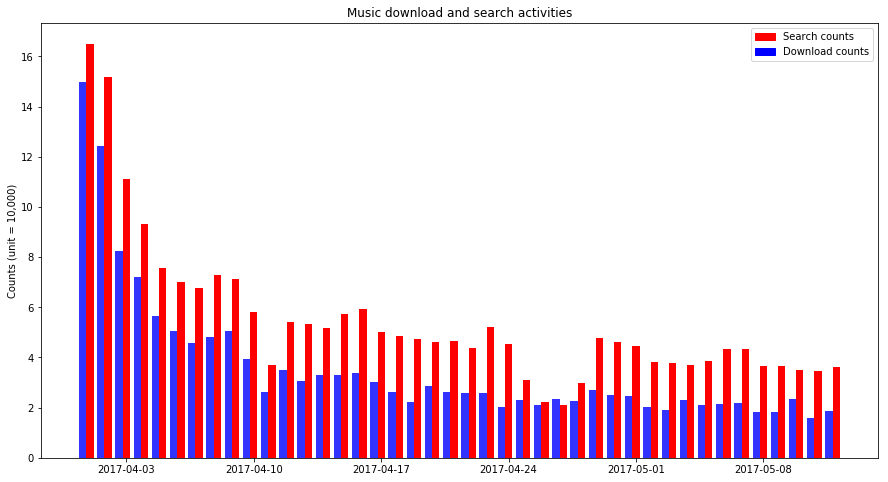

In [112]:
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.bar(x-0.4,D,width=0.4,color='b',align='center',alpha = 0.8)
ax.bar(x, S,width=0.4, color='r',align='center')
ax.xaxis_date()
plt.title('Music download and search activities')
plt.ylabel('Counts (unit = 10,000)')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Search counts')
blue_patch = mpatches.Patch(color='blue', label='Download counts')
plt.legend(handles=[red_patch, blue_patch])

I can see that searching times is more than downloading times. This makes sense.

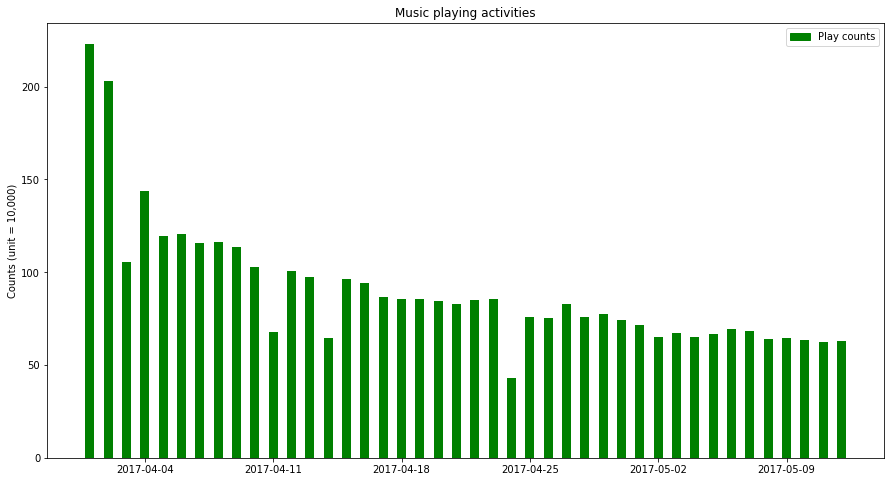

In [113]:
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.bar(x, P,width=0.5,color='g',align='center')
ax.xaxis_date()
plt.title('Music playing activities')
plt.ylabel('Counts (unit = 10,000)')

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='Play counts')
plt.legend(handles=[green_patch])

Overall, I can see the decresing trend of music play, music search and music download activities.

#### 3.2 What's the device distribution ?

In [123]:
df_device = df_filtered.groupBy('device').agg(
    F.countDistinct(F.col('uid')).alias('count'),
)
df_device.show()

+------+------+
|device| count|
+------+------+
|    ar|110466|
|    ip| 20074|
+------+------+



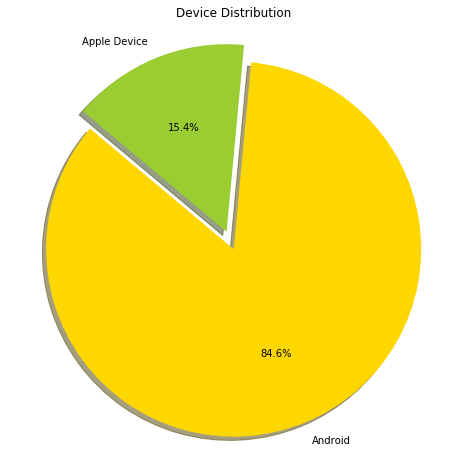

In [128]:
plt.figure(figsize=(8,8))
objects = ['Android', 'Apple Device'] 
sizes = list((110466,20074))
colors = ['gold', 'yellowgreen']
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=objects, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Device Distribution')
plt.show()

Android device holders are more active in this platform.

#### 3.3 What's the percentage of paid songs ?

In [130]:
df_filtered.groupBy('paid_flag').agg(
    F.countDistinct(F.col('song_id')).alias('count'),
).show()

+---------+------+
|paid_flag| count|
+---------+------+
|        0|857946|
|     null|     0|
+---------+------+



It indicates that this platform is a free music play platform.

#### 3.4 Why do users stop playing songs before it ends?
To answer this question, play_time compared to music length can be used as metric for this quiestion.

In [142]:
all_records = df_filtered.count()
records_less_than_ten = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.1).count()
records_less_than_twenty = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.2).count()
records_less_than_thirty = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.3).count()
records_less_than_fourty = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.4).count()
records_less_than_fifty = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.5).count()
records_less_than_sixty = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.6).count()
records_less_than_seventy = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.7).count()
records_less_than_eighty = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.8).count()
records_less_than_ninty = df_filtered.filter(F.col('play_time') < F.col('song_length') * 0.9).count()
records_less_than_hundred = df_filtered.filter(F.col('play_time') < F.col('song_length')).count()


In [165]:
x = (np.array(range(10)) + 1)/10.0
y = [
    records_less_than_ten/all_records,
    records_less_than_twenty/all_records,
    records_less_than_thirty/all_records,
    records_less_than_fourty/all_records,
    records_less_than_fifty/all_records,
    records_less_than_sixty/all_records,
    records_less_than_seventy/all_records,
    records_less_than_eighty/all_records,
    records_less_than_ninty/all_records,
    records_less_than_hundred/all_records
]

Text(0,0.5,'Percentage in all records')

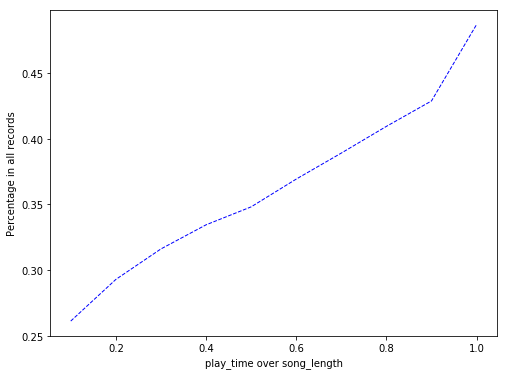

In [173]:
plt.figure(figsize=(8,6))
plt.plot(x,y,"b--",linewidth=1)
plt.xlabel('play_time over song_length')
plt.ylabel('Percentage in all records')

In [178]:
print('music play length < 10%% song_length: %f.' % (records_less_than_ten/all_records))
print('music play length < 20%% song_length: %f.' % (records_less_than_twenty/all_records))
print('music play length < 30%% song_length: %f.' % (records_less_than_thirty/all_records))
print('music play length < 40%% song_length: %f.' % (records_less_than_fourty/all_records))
print('music play length < 50%% song_length: %f.' % (records_less_than_fifty/all_records))
print('music play length < 60%% song_length: %f.' % (records_less_than_sixty/all_records))
print('music play length < 70%% song_length: %f.' % (records_less_than_seventy/all_records))
print('music play length < 80%% song_length: %f.' % (records_less_than_eighty/all_records))
print('music play length < 90%% song_length: %f.' % (records_less_than_ninty/all_records))
print('music play length < 100%% song_length: %f.' % (records_less_than_hundred/all_records))


music play length < 10% song_length: 0.261071.
music play length < 20% song_length: 0.292810.
music play length < 30% song_length: 0.316070.
music play length < 40% song_length: 0.334438.
music play length < 50% song_length: 0.348138.
music play length < 60% song_length: 0.369312.
music play length < 70% song_length: 0.389147.
music play length < 80% song_length: 0.409507.
music play length < 90% song_length: 0.428894.
music play length < 100% song_length: 0.487150.


In [183]:
y = [
    records_less_than_ten/records_less_than_hundred,
    (records_less_than_twenty - records_less_than_ten)/records_less_than_hundred,
    (records_less_than_thirty - records_less_than_twenty)/records_less_than_hundred,
    (records_less_than_fourty - records_less_than_thirty)/records_less_than_hundred,
    (records_less_than_fifty - records_less_than_fourty)/records_less_than_hundred,
    (records_less_than_sixty - records_less_than_fifty)/records_less_than_hundred,
    (records_less_than_seventy - records_less_than_sixty)/records_less_than_hundred,
    (records_less_than_eighty - records_less_than_seventy)/records_less_than_hundred,
    (records_less_than_ninty - records_less_than_eighty)/records_less_than_hundred,
    (records_less_than_hundred - records_less_than_ninty)/records_less_than_hundred
]

Text(0.5,1.05,'Distribution of early stopping')

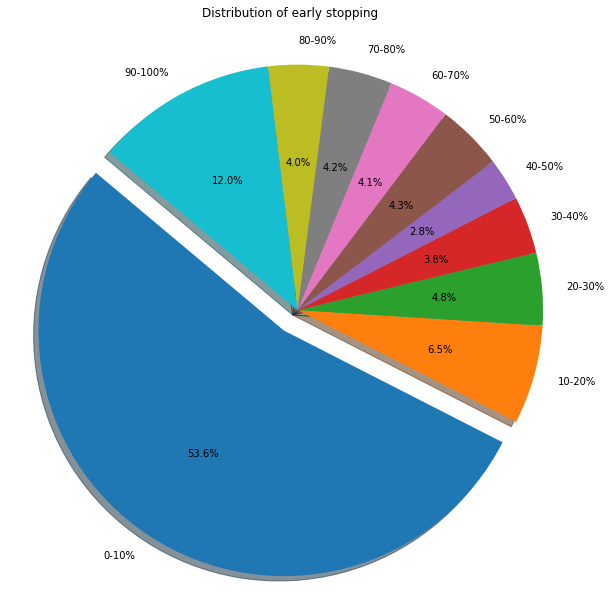

In [192]:
plt.figure(figsize=(10,10))
objects = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'] 
explode = (0.1, 0, 0, 0, 0,0 ,0 ,0 ,0 ,0)  # explode 1st slice
plt.pie(y, explode=explode, labels=objects,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of early stopping', y=1.05)

0% < play_time/song_length < 10% $\rightarrow$ 53.6% stop playing       
90% < play_time/song_length < 100% $\rightarrow$ 12.0% stop playing    
Remaining are similar.  

The reason that users stop playing before it ends:
1. User don't like the song after playing it for dozen seconds.
2. User like to jump to next when the current one is near end.

#### 3.5 What's the weekly retention rate for users? 


In [193]:
import datetime
from dateutil import parser
window_size = 7
period_one_start = parser.parse('2017-04-01').date()
period_one_end = period_one_start + datetime.timedelta(window_size - 1)
period_two_start = period_one_end + datetime.timedelta(1)
period_two_end = period_two_start + datetime.timedelta(window_size - 1)
period_three_start = period_two_end + datetime.timedelta(1)
period_three_end = period_three_start + datetime.timedelta(window_size - 1)
period_four_start = period_three_end + datetime.timedelta(1)
period_four_end = period_four_start + datetime.timedelta(window_size - 1)
period_five_start = period_four_end + datetime.timedelta(1)
period_five_end = period_five_start + datetime.timedelta(window_size - 1)
period_six_start = period_five_end + datetime.timedelta(1)
period_six_end = period_six_start + datetime.timedelta(window_size - 1)


In [200]:
period_one_id = df_filtered.filter((F.col('date')>=period_one_start) & (F.col('date')<=period_one_end))\
                    .select('uid').distinct()
period_two_id = df_filtered.filter((F.col('date')>=period_two_start) & (F.col('date')<=period_two_end))\
                    .select('uid').distinct()
period_three_id = df_filtered.filter((F.col('date')>=period_three_start) & (F.col('date')<=period_three_end))\
                    .select('uid').distinct()
period_four_id = df_filtered.filter((F.col('date')>=period_four_start) & (F.col('date')<=period_four_end))\
                    .select('uid').distinct()
period_five_id = df_filtered.filter((F.col('date')>=period_five_start) & (F.col('date')<=period_five_end))\
                    .select('uid').distinct()
period_six_id = df_filtered.filter((F.col('date')>=period_six_start) & (F.col('date')<=period_six_end))\
                    .select('uid').distinct()
    
    

In [215]:
period_one_retention = period_one_id.join(period_two_id,on=['uid'],how='inner').count()
period_two_retention = period_two_id.join(period_three_id,on=['uid'],how='inner').count()
period_three_retention = period_three_id.join(period_four_id,on=['uid'],how='inner').count()
period_four_retention = period_four_id.join(period_five_id,on=['uid'],how='inner').count()
period_five_retention = period_five_id.join(period_six_id,on=['uid'],how='inner').count()


In [216]:
x = np.array(range(5)) + 1
y = [
    period_one_retention/period_one_id.count(),
    period_two_retention/period_two_id.count(),
    period_three_retention/period_three_id.count(),
    period_four_retention/period_four_id.count(),
    period_five_retention/period_five_id.count(),
]

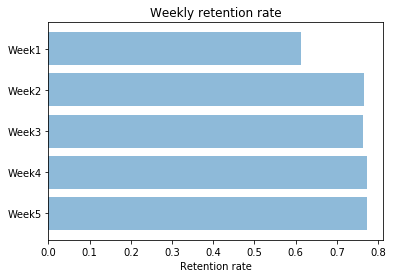

In [219]:
objects = list(('Week1', 'Week2', 'Week3', 'Week4', 'Week5'))
y_pos = np.arange(len(objects))
plt.barh(y_pos, y, align='center', alpha = 0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Retention rate')
plt.title('Weekly retention rate')
plt.gca().invert_yaxis()

I can see that the retention rate is quite stable during the six weeks. 